# The Niño 3.4 Index Time Series
### *Basic Analysis and Exploratory Hindcasting with Autoregressive Models & Neural Networks*

In this notebook, we discuss the Niño 3.4 index, a time series with a central role in climate science. 

The El Niño/Southern Oscillation (ENSO) phenomenon refers to a complex oscillatory (but not exactly periodic!) change in sea surface temperature, air pressure, and other oceanic & atmospheric state variables occurring around the southeastern Pacific on a time scale of about four years. ENSO also has a dramatic effect on weather patterns in other parts of the world: for instance, its "cycles" correspond to times of increased or decreased air moisture (& therefore precipitation) in North America. The Niño 3.4 index is one of many one-dimensional time series that ENSO oscillations. This index roughly represents the average sea-surface temperature at the equator in the southeastern Pacific.

Here, I'll explain how to obtain and clean the Niño 3.4 index dataset. I'll then discuss three simple approaches to hindcasting the 3.4 index: an autoregressive model, a fully-connected artificial neural network, and a recurrent artificial neural network. We'll find that, while the autoregressive model cannot express the complicated, (apparently) nonlinear oscillations in the dataset, it provides a much more reliable two-year hindcast than either of the artificial neural network-based approaches. In particular, the fully connected network I present here appears to be incapable of learning *any* interesting behaviour. 

### Sources/Recommended Reading
- *Statistical Methods for Climate Scientists*. DelSole & Tippett. Cambridge, 2022.

- *Nonlinear Climate Dynamics*, H. Dijkstra. Cambridge, 2013. 

- "Reconstructing computational system dynamics from neural data with recurrent neural networks". Durstewitz et al., Nature Rev. Neuroscience, 2023. See https://www.nature.com/articles/s41583-023-00740-7. 

- "Deep Learning: An Introduction for Applied Mathematicians". Higham and Higham, SIAM Rev. , 2019. Available online at https://epubs.siam.org/doi/10.1137/18M1165748.

- "Learning dynamical systems by recurrent neural networks from orbits". Kimura and Nakano, Neural Networks, 1998. See https://www.sciencedirect.com/science/article/abs/pii/S0893608098000987.

- "Forecasting the El Niño type well before the spring predictability barrier". Ludescher et al., npj Clim Atmos Sci, 2023. See https://www.nature.com/articles/s41612-023-00519-8. 

- "Forecasting El Niño with Convolutional and Recurrent Neural Networks". Mahesh et al., NeurIPS 2019. Available online at https://www.climatechange.ai/papers/neurips2019/40. 

-  "Monthly Climate Timeseries:
Niño 3.4 SST". NOAA. Available at https://psl.noaa.gov/data/timeseries/monthly/NINO34/

- "Recurrent Neural Networks for Dynamical Systems: Applications to Ordinary Differential Equations, Collective Motion, and Hydrological Modeling". Park et al. 2022 Available online at https://arxiv.org/abs/2202.07022.

- "Fundamentals of Recurrent Neural Network (RNN) and Long Short-Term Memory (LSTM) Network". Sherstinsky, Phys. D, 2023. For a preprint version see https://arxiv.org/pdf/1808.03314.

- "Nino SST Indices (Nino 1+2, 3, 3.4, 4; ONI and TNI)". UCAR. Available at https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni


### Setup & Imports

In [1]:
import joblib 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import scipy 
from scipy.interpolate import splrep, BSpline
from statsmodels.tsa.api import acf, graphics, pacf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.arima.model import ARIMA

# this makes sure the images don't come out looking muddy on 
# retina displays (which your computer probably uses)
%config InlineBackend.figure_format='retina'

# set up nice fonts for plotting 
plt.rc('font', family='serif')

# set up plot size and other params
plt.rcParams["figure.figsize"] = (5,4)
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True
plt.rcParams["axes.edgecolor"] = 'k'

### Loading and Cleaning the Data

Data on the 3.4 index is available for download at https://psl.noaa.gov/data/timeseries/monthly/NINO34/. However, this data must be supplemented with proper labels and cleaned before use. In particular, it comes with no explicit month labels, so our first task is to place these in manually. 

In [2]:
path = "data/nina34.data.txt"
names = ["Year", 
         "January", 
         "February", 
         "March", 
         "April", 
         "May", 
         "June", 
         "July", 
         "August", 
         "September", 
         "October", 
         "November", 
         "December"]
df_raw = pd.read_csv(path, sep=' ', engine='python', skipfooter=3, names=names, skipinitialspace=True)
df_raw.head()

,Year,January,February,March,April,May,June,July,August,September,October,November,December
0,1948,2025.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1948,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99
2,1949,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99
3,1950,24.55,25.06,25.87,26.28,26.18,26.46,26.29,25.88,25.74,25.69,25.47,25.29
4,1951,25.24,25.71,26.90,27.58,27.92,27.73,27.60,27.02,27.23,27.20,27.25,26.91


Let's focus on the years 1990-2018 (left-endpoint inclusion, right-endpoint exclusive). Note that this is *not* the choice made in the DelSole & Tippett book even though many of their plots only focus on 1990-2000: if you want to reproduce their figures more closely, *you must use 1950-2018 in your data*!

We'll also have to turn the time series values into a single array. Fortunately, we can use built-ins to collapse our dataframe to a single array, then just drop the years with a simple filter (this relies on our responding variable values being much less than 1990 in this particular case!). We summarize this inside a cleaning function. 

In [3]:
def clean_time_series(start_year, end_year):
    x = df_raw[(df_raw["Year"] >= start_year) &  (df_raw["Year"] < end_year)].to_numpy().flatten()
    x = x[x < start_year]

    t_months = np.arange(0, x.size)
    t_years = start_year + t_months/12

    return {"t_months": t_months, 
            "t_years": t_years, 
            "time_series": x
           }

In [4]:
start_year = 1990
end_year = 2000

training_time_series_dict = clean_time_series(start_year, end_year)
t_months = training_time_series_dict["t_months"]
t_years = training_time_series_dict["t_years"]
x = training_time_series_dict["time_series"]

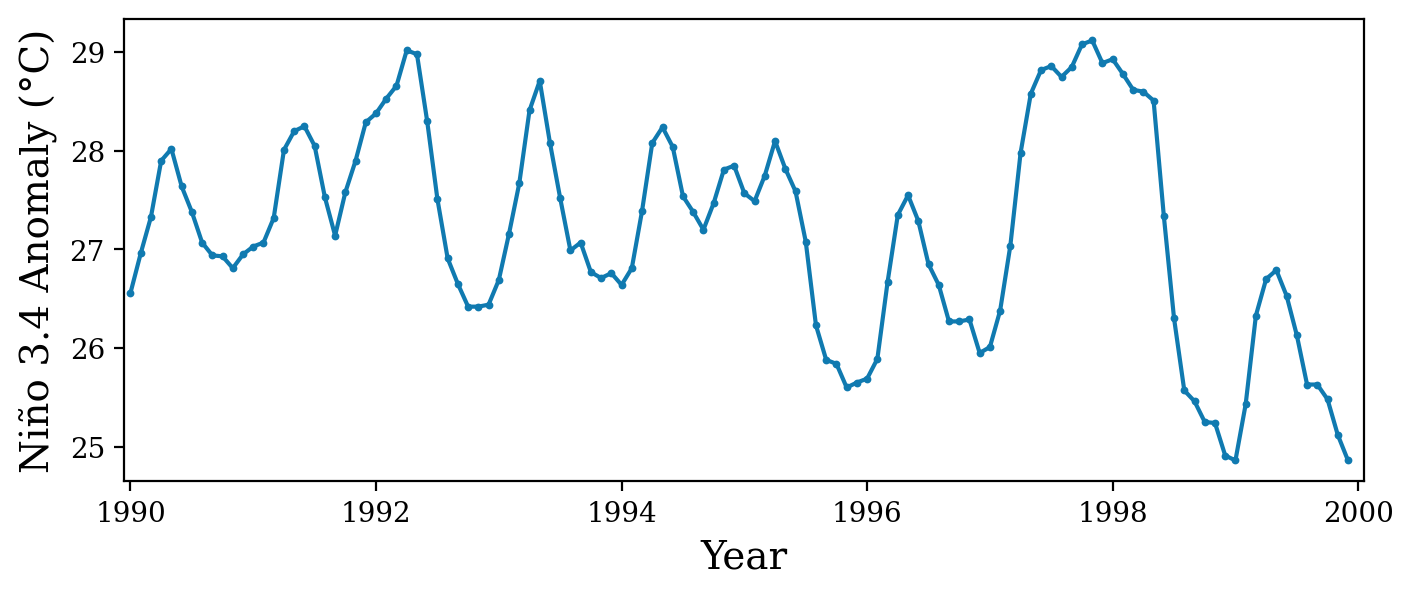

In [5]:
fig, ax=plt.subplots()
plt.plot(t_years, x, 'o-', markersize=1.8, color="xkcd:nice blue")
plt.xlabel("Year", fontsize=14)
plt.ylabel("Niño 3.4 Anomaly (°C)", fontsize=14)
plt.xlim(start_year - 0.05, end_year + 0.05)
fig.set_size_inches(8, 3)  
plt.show()

### Removing Seasonality with Linear Regression

Clearly, our index must be coupled to seasonal variations (cold season/hot season) owing to the motion of the Earth around the sun. So, some of the oscillations in the data can be explained by seasonality. In this section, we'll use linear regression (the method of least squares) to filter out seasonality to extract the so-called **anomaly** time series.

We shall fit our data to a trigonometric polynomial in time. We use the convention that the linear model parameters alternative between cosine and sine, so even-indexed entries correspond to cos and odd-indexed entries correspond to sin: if $p$ is the degree of our trigonometric polynomial then

$$
(a_0, b_1, a_1, b_2, a_2, ..., b_{p}, a_{p})
$$

The choice $p=2$ is natural because it allows us to capture the data mean $k=0$, annual-scale events $k=1$, and warm-cold seasonality $k=2$.  

In [6]:
def A_func(times, p=2):
    """Matrix appearing in least-squares fit, depending on the sampled "times" and the 
    degree "p" of the trend trig. polynomial. Time is assumed to be in months here!"""
    out = np.ones((times.size, int(2*p+1)), dtype=float)
    for j in range(0, times.size):
        theta = 2.*np.pi*times[j]*np.arange(1, p+1)/12. 
        out[j, 1::2] = np.sin(theta)
        out[j, 2::2] = np.cos(theta)
    return out

In [7]:
A = A_func(t_months, p=2)

fit_result = np.linalg.lstsq(A, x, rcond=None)
fit_params = fit_result[0]

rank = fit_result[2]
print("A has 5 columns and rank ", rank)

s = fit_result[3]
cond =  np.amax(s)/np.amin(s)
print("The condition # of A (in the singular value sense) is about %.3f" % cond)

A has 5 columns and rank  5
The condition # of A (in the singular value sense) is about 1.414


$A$ has full rank and is beautifully conditioned, so we can trust the results of our fit! 

In [8]:
estimated_trend = A @ fit_params
anomaly =  x - estimated_trend

# We've done a lot of preprocessing to get to this point, so you may want to save the anomaly time series for convenience later on.
# np.savetxt("nino34_anomaly.csv", anomaly, delimiter=",")

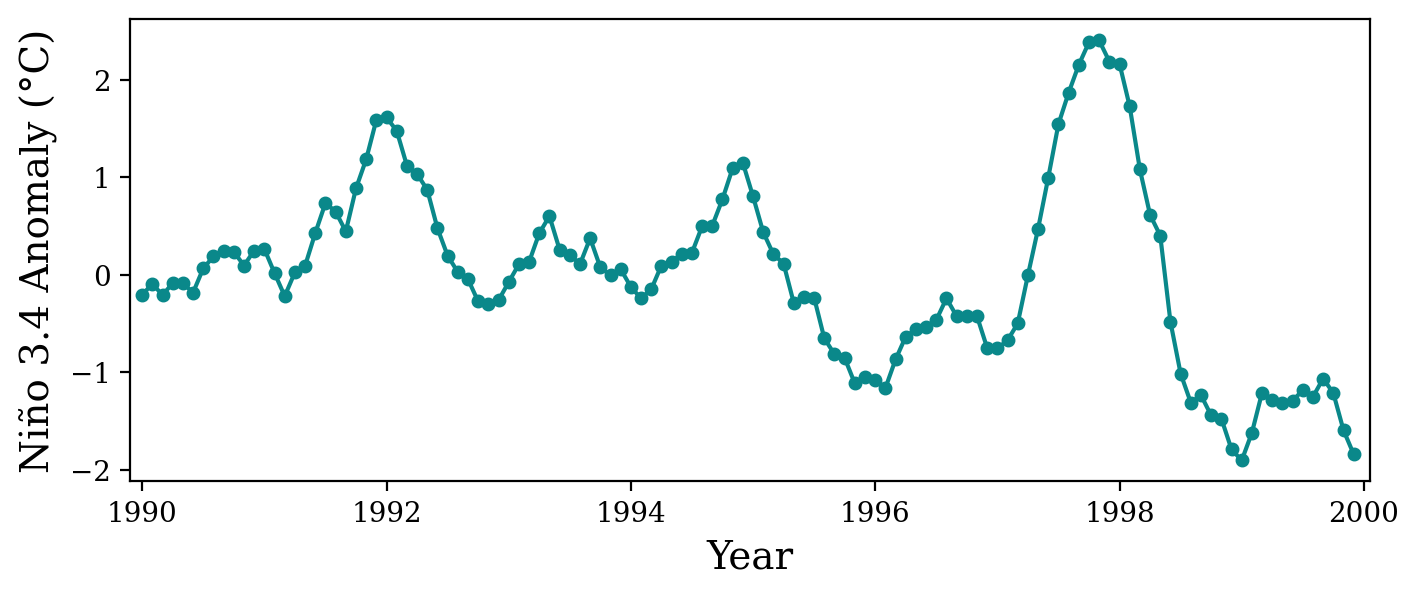

In [9]:
fig, ax = plt.subplots()
plt.plot(t_years, anomaly, 'o-', markersize=4, color="xkcd:dark cyan")
plt.xlabel("Year", fontsize=14)
plt.ylabel("Niño 3.4 Anomaly (°C)", fontsize=14)
plt.xlim(1989.9, 2000.05)
fig.set_size_inches(8, 3)  
plt.show()

### Statistical Properties of the Anomaly

Going forward, let's denote the anomaly by 

$$
Z_t = X_{t} - \mu_t.  
$$

To start to understand the autocorrelation in the series, we can plot $Z_{t+1}$ against $Z_{t}$: 

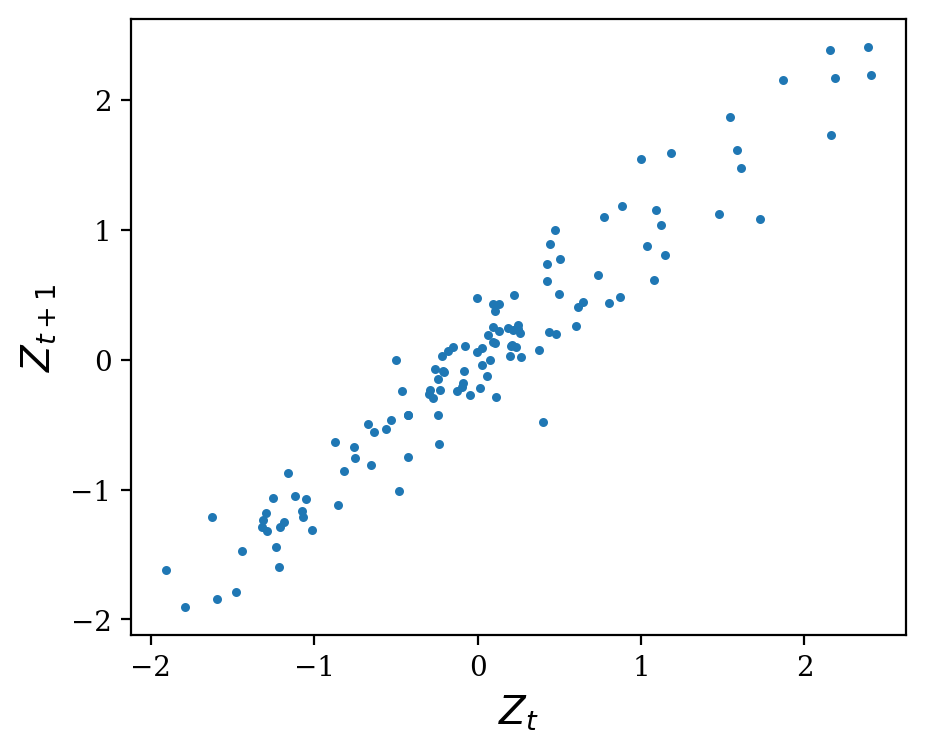

In [10]:
plt.scatter(anomaly[:-1], anomaly[1:], s = 5)
plt.xlabel("$Z_t$", fontsize=14)
plt.ylabel("$Z_{t+1}$", fontsize=14)
plt.show()

Linear correlation between consecutive steps is pretty clear from this picture. Let's quantify this by computing the Pearson-$r$ correlation coefficient. 

In [11]:
r = scipy.stats.pearsonr(anomaly[:-1], anomaly[1:]).statistic
print("The Pearson correlation between Z_t and Z_t+1 is about r = %.4f" % r)

The Pearson correlation between Z_t and Z_t+1 is about r = 0.9635


The statsmodels package has a built-in function for computing the autocorrelation function (ACF) evaluated at an automatically-determined number of lags. 

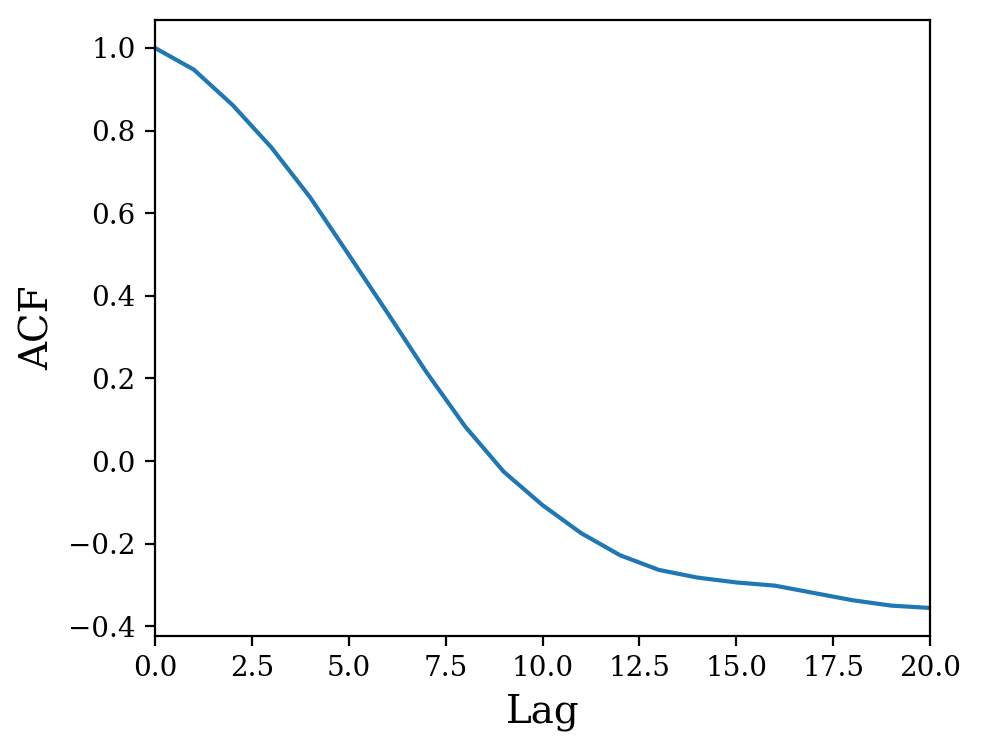

In [12]:
sm_acf = acf(anomaly)
lags = np.arange(0, sm_acf.size)
plt.plot(lags, sm_acf)
plt.xlabel("Lag", fontsize=14)
plt.ylabel("ACF", fontsize=14)
plt.xlim([0,20])
plt.show()

We should be careful and check that what statsmodels spits out agrees with our conventions etc.: 

In [13]:
def acv_basic(tau): 
    return np.dot(anomaly[:t_months.size - int(abs(tau))], anomaly[int(abs(tau)):]) / (t_months.size)

acv = np.vectorize(acv_basic)
my_acf = lambda tau: acv(tau)/acv(0)

acf_difference = np.amax(np.abs( my_acf(lags) - sm_acf))
print("The magnitude of the maximum difference between the statsmodels and homemade CDFs is %.1e ." % acf_difference)

The magnitude of the maximum difference between the statsmodels and homemade CDFs is 2.9e-15 .


So, to machine precision the statsmodels built-in function gives the correct answer!

Note in particular that the ACF displays structure: it doesn't just spike up at $0$. This implies that the oscillations in the anomaly are not due to purely stochastic effects. 

# Modelling and Hindcasting with an Autoregressive Model

Now, let's use statsmodels to fit a degree-2 autoregressive (AR(2)) model to the anomaly data. This involves *assuming* that $Z_t$ oveys the recursion

$$
Z_{t} = \alpha_1 Z_{t-1} + \alpha_{2} Z_{t-2} + \epsilon_{t}
$$

where $\alpha_1, \alpha_2\in \mathbb{R}$ are model parameters and $\epsilon_t$ is a random noise term. 

The statsmodels package AutoReg function uses likelihood optimization to determine the "best" $\alpha_1, \alpha_2$ capable of explaining the observed time series. 

In [14]:
mod = AutoReg(anomaly, 2)
res = mod.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  120
Model:                     AutoReg(2)   Log Likelihood                  15.744
Method:               Conditional MLE   S.D. of innovations              0.212
Date:                Fri, 28 Feb 2025   AIC                            -23.489
Time:                        16:40:20   BIC                            -12.406
Sample:                             2   HQIC                           -18.989
                                  120                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0074      0.020     -0.381      0.703      -0.046       0.031
y.L1           1.5081      0.077     19.493      0.000       1.356       1.660
y.L2          -0.5561      0.078     -7.097      0.0

Let's see how good the AR(2) model is at reproducing the observed anomaly: 

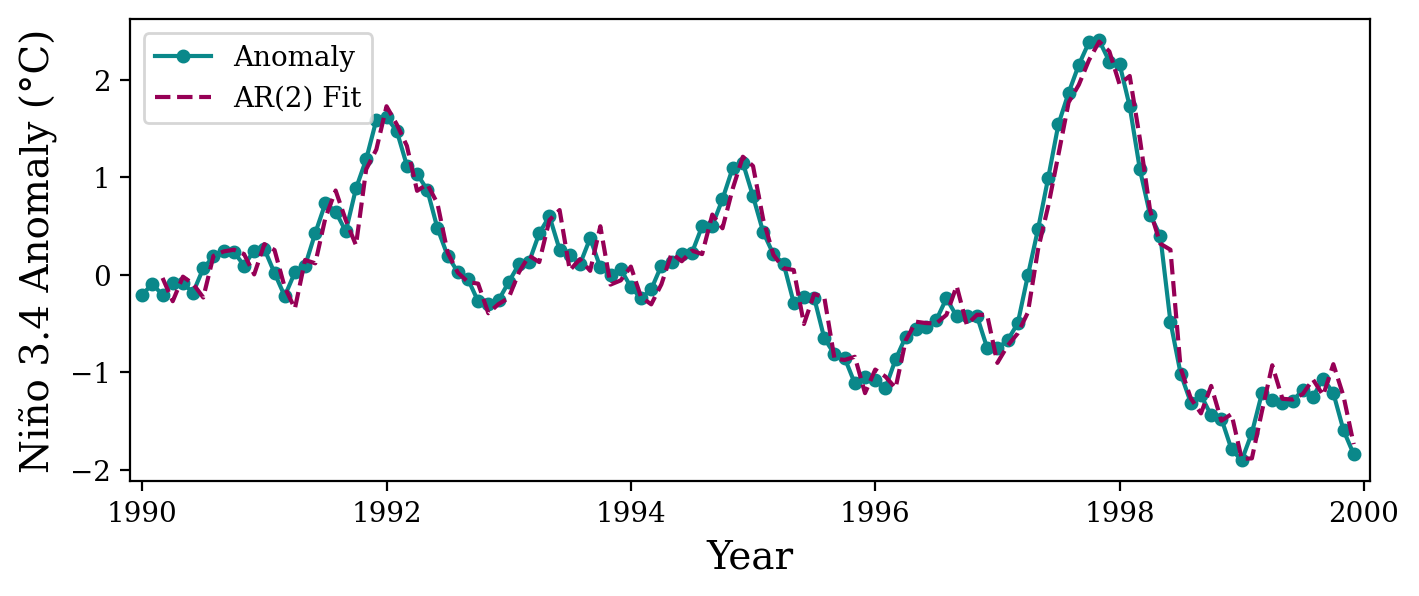

In [15]:
ar2_prediction = res.predict()

fig, ax = plt.subplots()
plt.plot(t_years, anomaly, 'o-', markersize=4, color="xkcd:dark cyan", linewidth="1.5", label="Anomaly")
plt.plot(t_years, ar2_prediction, color="xkcd:dark magenta", linestyle="dashed", linewidth="1.5", label="AR(2) Fit")
plt.xlabel("Year", fontsize=14)
plt.ylabel("Niño 3.4 Anomaly (°C)", fontsize=14)
plt.xlim(1989.9, 2000.05)
ax.legend(loc="best")
fig.set_size_inches(8, 3)  
plt.show()


So, our model has passed step 0, namely agreeing with the data it was trained on! Crucially, it does not appear to be overfitting. 

Let's see how good our model is at hindcasting the Niño 3.4 index from Jan. 2000 onwards, which we left out of all our training data. First, let's get some test data. 

In [16]:
test_start_year = end_year - 2 
test_end_year = 2004

test_time_series_dict = clean_time_series(test_start_year, test_end_year)
test_t_months = test_time_series_dict["t_months"]
test_t_years = test_time_series_dict["t_years"]
test_x = test_time_series_dict["time_series"]

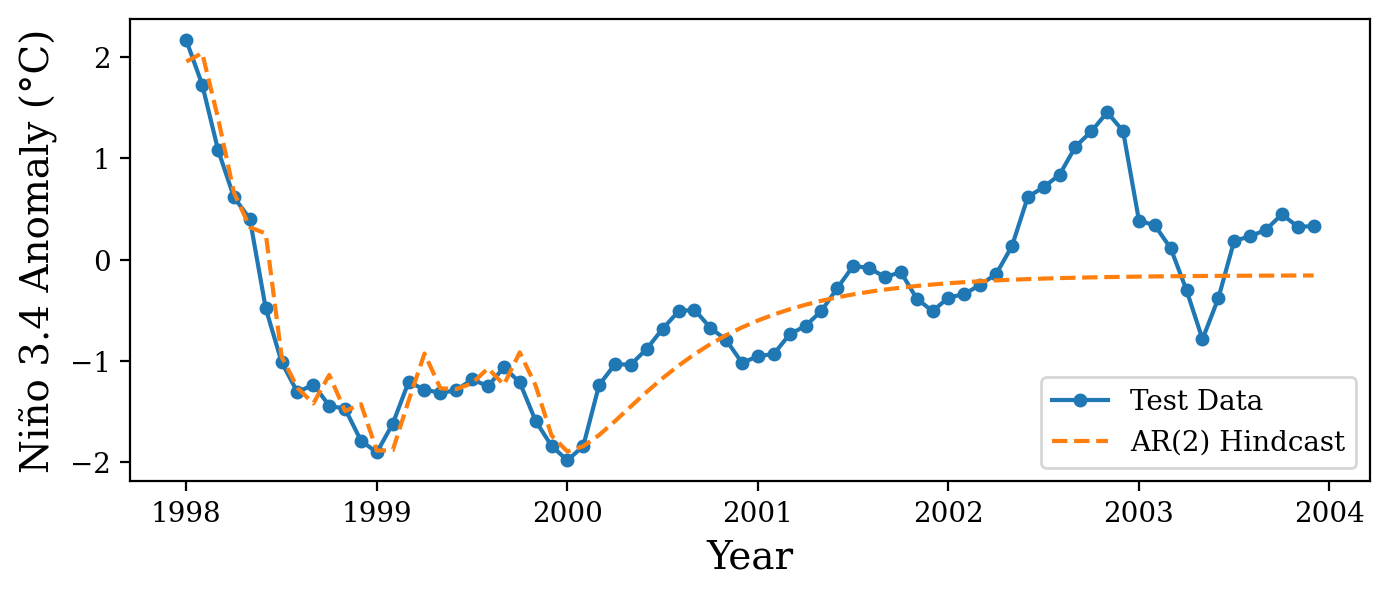

In [17]:
ar2_hindcast = res.predict(start=t_months[-24], end=t_months[-24] + test_t_months[-1])

fig, ax = plt.subplots()
plt.plot(test_t_years, test_x - A_func(t_months[-24] + test_t_months, p=2) @ fit_params ,  'o-', label="Test Data", markersize=4)
plt.plot(test_t_years, ar2_hindcast, label="AR(2) Hindcast", linestyle="dashed")
plt.xlabel("Year", fontsize=14)
plt.ylabel("Niño 3.4 Anomaly (°C)", fontsize=14)
ax.legend(loc="best")
fig.set_size_inches(8, 3)  
plt.show()

Based on these experiments it appears that a simple AR(2) provides a decent hindcast for just over two years! Beyond this window, the monotonic AR(2) prediction cannot do much good: it cannot explain the oscillations in the time series, but it can locally determine the near-future trend. 

Can we improve on the AR(2) model? Since this model is *linear*, it's natural to seek improvements via *nonlinear* methods.  

## Hindcasting with an Artificial Neural Network Part

In the past decade or so, artificial neural networks (ANNs) have become popular tools for learning complex, nonlinear patterns in datasets (see Higham and Higham 2019). 

Since we want to understand the influence of nonlinearity in the El Niño 3.4 index and there is plenty of well-supported modern software for desiging and deploying ANNs, it seems like a good idea to try and obtain improved hindcasts via ANNs. 

First, we need to import a neutral network library. Let's use PyTorch for today [comment from future me: in retrospect I think Tensorflow would have been a better choice since we won't make use of GPUs for training and PyTorch requires a little bit of massaging when talking to NumPy]. 

In [18]:
import torch
from torch import nn

device = "cpu"

### Attempt 1: Fully-Connected Network

The goal here is to assume that the anomaly is governed by a discrete-time dynamical system that has been perturbed by noise:

$$
Z_{t} = f\left(Z_{t-1}\right) + \epsilon_t
$$

The goal is to learn the function $f(Z)$ generating this dynamics using "orbit slices" (subsequences of the anomaly time series). That is, we *assume* our dynamics is generated by an ANN depending on parameters $\theta$, 

$$
f(Z) = \text{ANN}\left(Z; \theta\right),
$$

then use the data to learn the "optimal" value of all the parameters in $\theta$. In this context, "optimality" refers to how well this model can reproduce known orbit slices via successive compositions of the ANN with itself: this follows Bramburger's approach in https://github.com/jbramburger/DataDrivenDynSyst/blob/main/Learning%20Dynamics%20with%20Neural%20Networks/Forecast.ipynb. 

Since we're really just trying to learn a nonlinear map, it makes sense to just use a basic fully-connected ANN. This means the network is just made of stacked dense linear layers and nonlinear activations. 

In [19]:
class AutonomousDynamicsForecaster(nn.Module):
    def __init__(self, state_space_dim = 1, num_hidden_layers = 8, num_neurons_per_layer = 20):
        super().__init__()
        self.flatten = nn.Flatten(start_dim=0, end_dim=-1)

        # Initialize the fully-connected network
        self.fcn = nn.Sequential()

        # Input & first hidden layer
        self.fcn.add_module("dense_0", nn.Linear(state_space_dim,num_neurons_per_layer,bias=True))
        self.fcn.add_module("activation_0", nn.ReLU())

        # Middle hidden layers
        for layer in range(1, num_hidden_layers):
            self.fcn.add_module(f"dense_{layer}", nn.Linear(num_neurons_per_layer,num_neurons_per_layer,bias=True))
            self.fcn.add_module(f"activation_{layer}", nn.ReLU())

        # Output layer
        self.fcn.add_module(f"dense_{num_hidden_layers}", nn.Linear(num_neurons_per_layer,state_space_dim))

    def forward(self, y):
        return self.fcn(self.flatten(y)) # so that y_{t}->y_{t+1}

In [20]:
ann_forecaster = AutonomousDynamicsForecaster(state_space_dim = 1, num_hidden_layers = 4, num_neurons_per_layer = 20)

In [21]:
#y_train = torch.from_numpy(np.vstack((t_months, anomaly)))
y_train = torch.from_numpy(anomaly)
y_train = y_train.to(torch.float32)
y_train.shape

torch.Size([120])

Following Bramburger, we re-organize the training data into long orbit slices. 

In [22]:
def get_slices_train(y_train, slice_length = 12):
    """
    Processes a time series of training data into a tensor of orbit slices. 
    
    Assumes that the tensor y_train has shape "dim. of state space" x "num. of samples in time series"!
    """
    return torch.stack([y_train[t:t+slice_length] for t in range(1, y_train.shape[0] - slice_length+1)])

In [23]:
slice_length = 4
slices_train = get_slices_train(y_train, slice_length = slice_length)
slices_train.shape

torch.Size([116, 4])

In [24]:
def tensorify(a):
    t = torch.from_numpy(a)
    return t.to(torch.float32)

def detensorify(t):
    return t.detach().numpy()

In [25]:
tensorify(np.array([4,5,6]))

tensor([4., 5., 6.])

In [26]:
t = torch.tensor([4,5,6])
detensorify(t)

array([4, 5, 6])

In [27]:
def get_orbit_slice(forecaster, y0, slice_length = 12): 
    """Get an orbit slice by passing some time + state y0 through the forecaster.
    This should be a proxy for the orbit slice [y_1, y_2, ..., y_{slice_length-1} ]"""
    slice = []
    slice.append(y0)
    for t in range(slice_length):
        slice.append(forecaster.forward(slice[t])) # this is to try and avoid in-place modification
    return torch.reshape(torch.stack(slice[1:]), (slice_length,))

In [28]:
learning_rate = 2e-2
optimizer = torch.optim.Adam(ann_forecaster.parameters(), lr=learning_rate)

In [29]:
import time

torch.autograd.set_detect_anomaly(False)

num_epochs = int(1.5e2)
cleaned_y_train = y_train[:-slice_length]
loss_fn = nn.MSELoss()

start = time.time()
losses = np.zeros(num_epochs)

for n in range(num_epochs):
    slices_predicted = torch.stack([
        get_orbit_slice(
            ann_forecaster, cleaned_y_train[t], slice_length=slice_length
        ) for t in range(len(cleaned_y_train))
    ])

    loss = loss_fn(slices_predicted, slices_train)
    
    # Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()   

    losses[n] = loss
    # print(n, loss)

end = time.time()
runtime = end - start
print("Training time = %.3f seconds" %runtime)

Training time = 7.397 seconds


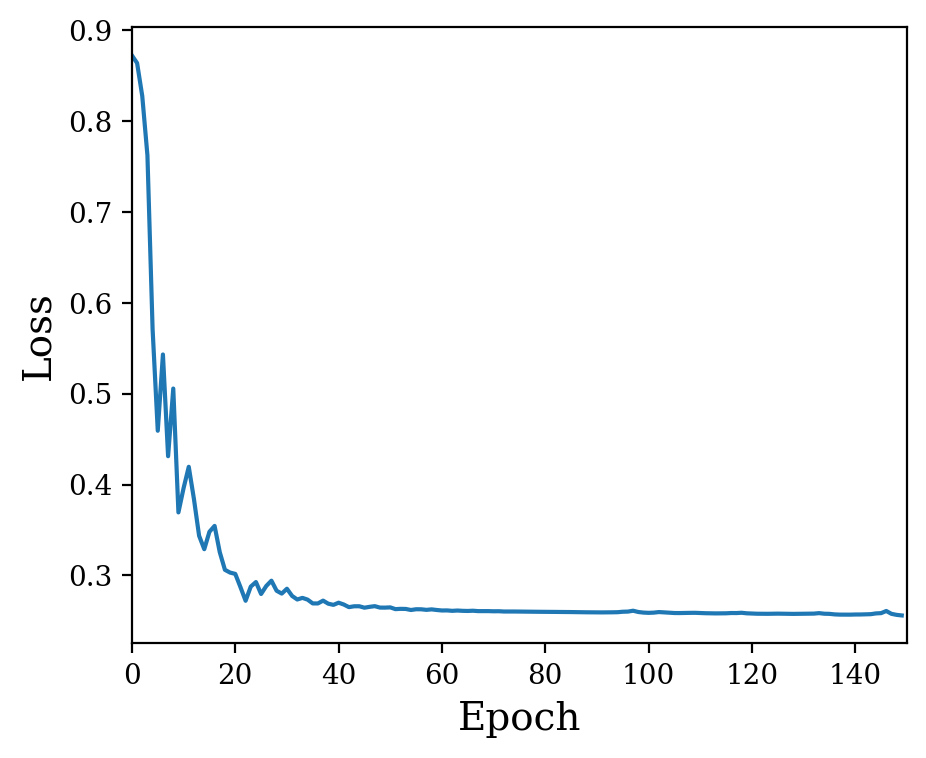

In [30]:
plt.plot(range(num_epochs), losses)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.xlim([0,num_epochs])
plt.show()

In [31]:
def get_ann_hindcast():
    ann_hindcast = np.zeros(12*6)
    initial_state = anomaly[12*8]
    ann_hindcast[0] = initial_state
    for t in range(12*6-1):
        ann_hindcast[t+1] = ann_forecaster.forward(tensorify(np.array(ann_hindcast[t])))
    return ann_hindcast

In [32]:
ann_hindcast = get_ann_hindcast()

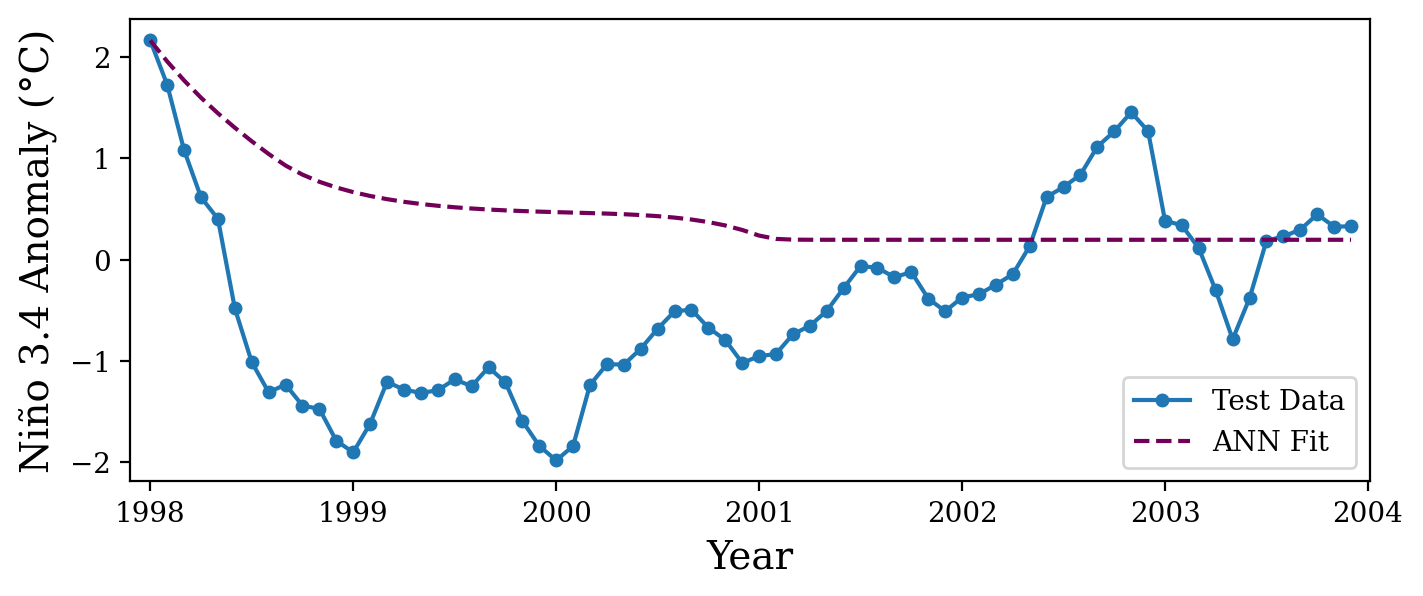

In [33]:
fig, ax = plt.subplots()
plt.plot(test_t_years, test_x - A_func(t_months[-24] + test_t_months, p=2) @ fit_params ,  'o-', label="Test Data", markersize=4)
plt.plot(test_t_years, ann_hindcast, color="xkcd:rich purple", linestyle="dashed", linewidth="1.5", label="ANN Fit")
ax.legend(loc="best")
plt.xlabel("Year", fontsize=14)
plt.ylabel("Niño 3.4 Anomaly (°C)", fontsize=14)
plt.xlim([1998-0.1, 2004+0.01])
fig.set_size_inches(8, 3)  
plt.show()

It seems that the predictions of the ANN are really bad! They don't appear to capture much except relaxation to equilibrium, which is not a feature of our time series!

What is going on? Perhaps it is more instructive to see the dynamics-generating function that the network learned: 

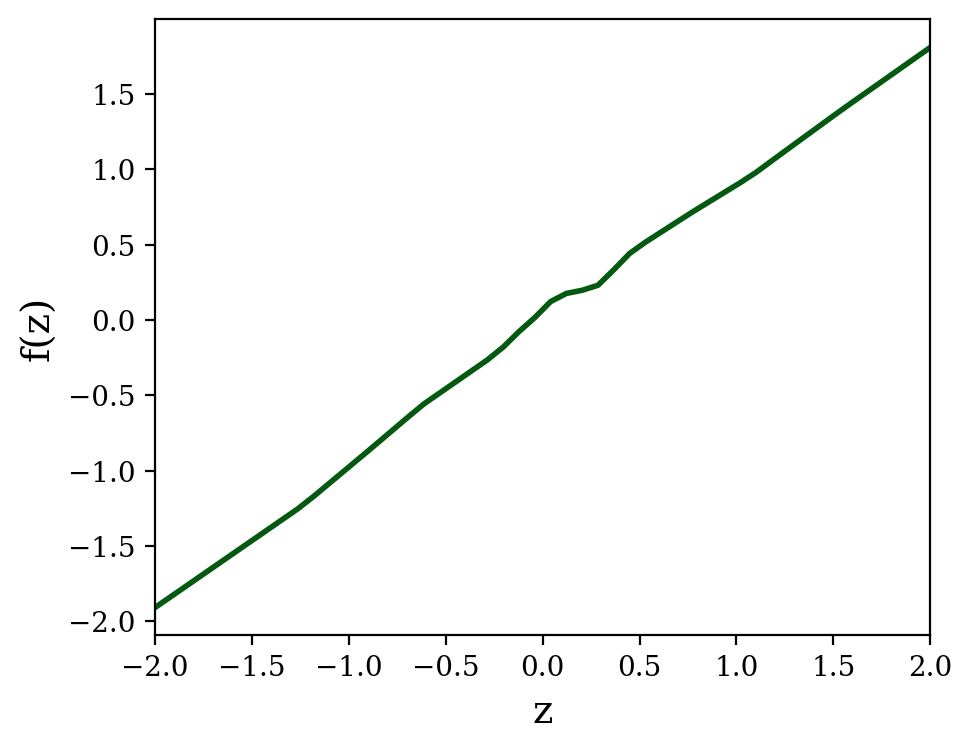

In [34]:
zz = np.linspace(-2, 2)
ff = np.zeros_like(zz)
for k in range(ff.size):
    ff[k] = detensorify(ann_forecaster.forward(tensorify(np.array(zz[k]))))[0]
plt.plot(zz, ff, linewidth="2", color="xkcd:deep green")
plt.xlabel("z", fontsize=14)
plt.ylabel("f(z)", fontsize=14)
plt.xlim([-2,2])
plt.show()

As things stand it seems that the ANN fails to learn any nonlinear dynamics! Messing around with the slice length and activation function give us some minor improvements, but nothing that's acceptable beyond a month or two. This is even worse than AR(2)! 

So, a simple fully-connected network is insufficient, and we should turn to a more complicated architecture. 

### Attempt 2: Recurrent Neural Network

At a conceptual recurrent neural network (RNN) is basically a souped-up, nonlinear version of an AR-type models: both involve looking "backward in time". RNNs are especially popular for the analysis of time series arising from dynamical systems. For some recent literature on applications of RNNs see for instance Durstewitz et al. and Park et al. For more foundational discussion on the connection between RNNs and dynamics, see Kimura \& Nakano or Sherstinsky. Finally, for some more complete work on the use of RNNs in El Nino hind/forecasting (far more comprehensive than the discussion here!), see Mahesh et al.   

To use an RNN effectively, we should prescribe the hindcast window. Since AR(2) did decently for a little over two years and we want to see an improvement over this simple model, let's ask for a three-year hindcast (from January 2000 to December 2002 inclusive) for starters. 

Our training data will be a whole bunch of El Nino subsequences, similar to the orbit slices from attempt 1. Seeing these, the network will try to learn how to predict the anomaly for the next three years. 

That is, the network *input* is an orbit slice from year $t$ to year $t+\tau$ and the network *output* is a sequence lasting from year $t+3$ to $t+\tau+3$, such that the concatenated subsequence lasting from year $t$ to year $t+\tau+3$ could itself be a reasonable orbit slice. Strictly speaking, because of the implicitly time-dependent nature of RNNs, the actual sample length $\tau$ will be absent from the network definition in the code below. 

With all this in mind, to get a good model we may have to use training data from earlier than 1990: with the output being three years, the natural value of $\tau$ if we restricted ourselves would certainly be less than $\tau=7$, which seems far too small to have a hope of a good hindcast. 

For a start, let's try $\tau=10$ years. So, if we want to start our hindcast in January 2000, the last training output should stop in December 1999 (ie. it lasts from Jan. 1990 to Dec. 1999), hence the last training input should start in January 1987 and end in December 1996. Since the training data goes reliably only back to 1950 and we can get a training sample for each year from January 1950 to January December 1987, we would get about 37 training samples if we separated data year-by-year. If we work in units of months instead (so the network maps 120-month slices to 36-month slices), this goes up to about $12*37=444$ training samples (give or take a month owing to counting a zero) which seems a lot better.  

We can now define our RNN: 

In [35]:
# Define the RNN
class AutonomousDynamicsRecurrentForecaster(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(AutonomousDynamicsRecurrentForecaster, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True) 
        # ^ see the RNN class docs here: https://pytorch.org/docs/stable/generated/torch.nn.RNN.html
        self.fc = nn.Linear(hidden_dim, output_dim) # needed to make sensible outputs, see Geron's book
    
    def forward(self, x):
        # Note here: it looks like a lot of the actual ANN construction 
        # when using a torch RNN happens in the forward method rather 
        # than in the init!
        h0 = torch.zeros(num_layers, x.size(0), hidden_dim).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out)
        return out

input_dim = 1 # input state space dim (!NOT! input sequence length)
hidden_dim = 16 # number of neurons in each hidden layer
num_layers = 2 # number of reccurent hidden layers
output_dim = 1 # output state space dim (!NOT! output sequence length)

rnn_forecaster = AutonomousDynamicsRecurrentForecaster(input_dim, hidden_dim, output_dim, num_layers=num_layers)

Next, we'll make the training data. We have to de-trend again since we're changing our time window. 

In [36]:
start_year = 1950
end_year = 2003

time_series_dict = clean_time_series(start_year, end_year)
t_months = time_series_dict["t_months"]
t_years = time_series_dict["t_years"]
x = time_series_dict["time_series"]

In [37]:
A = A_func(t_months, p=2)

fit_result = np.linalg.lstsq(A, x, rcond=None)
fit_params = fit_result[0]

rank = fit_result[2]
print("A has 5 columns and rank ", rank)

s = fit_result[3]
cond =  np.amax(s)/np.amin(s)
print("The condition # of A (in the singular value sense) is about %.3f" % cond)

A has 5 columns and rank  5
The condition # of A (in the singular value sense) is about 1.414


In [38]:
estimated_trend = A @ fit_params
anomaly =  x - estimated_trend

slice_length = 10*12 # num of months we train for: what we called "tau" in the intro text
forecast_window = 3*12

anomaly_train = anomaly[:-forecast_window]

# Will need this for later!
anomaly_test_in = anomaly[-forecast_window-slice_length:-forecast_window]
anomaly_test_out = anomaly[-slice_length:]

Now we come to assembling the training slices. The function that gets our training data can be called with a smoothing parameter $s\geq 0$ (globally called `smoothing_param`): $s=0$ implements no smoothing, and $s>0$ implements smoothing via B-splines. I found some smoothing useful in getting the network to ignore high-frequency wiggles in the dataset.  

In [39]:
smoothing_param = 1.5

def get_smoothed_slice(times, slice, s=1.):
    """Use a cubic spline to smooth an orbit slice "slice" (an nparray) defined
    over the  time interval "times" (also an nparray)"""
    tck = splrep(times, slice, s=s)
    # evaluate the spline throughout the interval of interest
    return BSpline(*tck)(times)

To get an idea for the effect of our smoothing parameter, let's plot a slice of the time series and the smoothed version of that slice. 

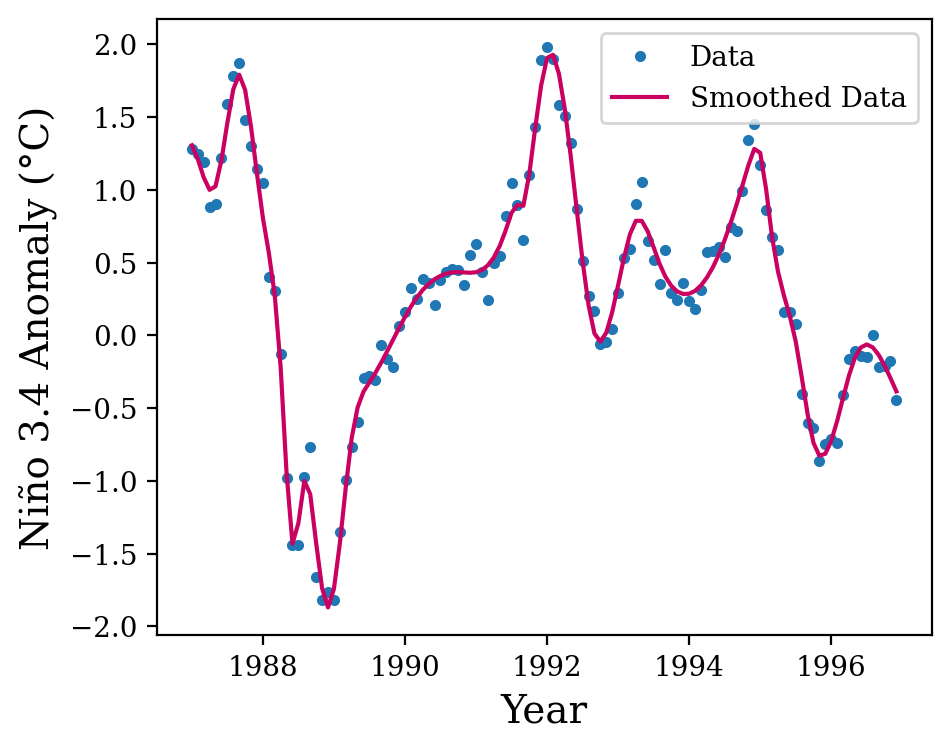

In [40]:
times_final = t_years[(t_years >= 1987) & (t_years < 1997)]
slice_final = anomaly[(t_years >= 1987) & (t_years < 1997)]
plt.plot(times_final, slice_final, 'o', markersize=3, label="Data")
plt.plot(times_final, get_smoothed_slice(times_final, slice_final, s=smoothing_param), label="Smoothed Data", color="xkcd:deep pink")
plt.xlabel("Year", fontsize=14)
plt.ylabel("Niño 3.4 Anomaly (°C)", fontsize=14)
plt.legend(loc="best")
plt.show()

In [41]:
def get_slices_train(ts, s = 1., slice_length = 10*12, forecast_window = 3*12):
    """
    Processes a time series of training data into a dict of training data (inputs and outputs)
    consisting of orbit slices/subsequences of the time series
    
    Assumes that the tensor y_train has shape "dim. of state space" x "num. of samples in time series"!
    """
    num_samples = ts.shape[0]

    all_times = range(0, num_samples)

    # Get input data 
    input_slices = [ts[t:t+slice_length] for t in all_times[:num_samples - slice_length + 1-forecast_window]]
    input_times = [all_times[t:t+slice_length] for t in all_times[:num_samples - slice_length + 1-forecast_window]]
    smoothed_input_slices = [
        torch.tensor(
            get_smoothed_slice(times, slice, s=s),
            dtype=torch.float32
        ) for (times, slice) in zip(input_times, input_slices)
    ]

    # Get output data
    output_slices = [ts[t:t+slice_length] for t in all_times[forecast_window:num_samples - slice_length + 1]]
    output_times = [all_times[t:t+slice_length] for t in all_times[forecast_window:num_samples - slice_length + 1]]
    smoothed_output_slices = [
        torch.tensor(
            get_smoothed_slice(times, slice, s=s), 
            dtype=torch.float32
        ) for (times, slice) in zip(output_times, output_slices)
    ]

    return torch.stack(smoothed_input_slices), torch.stack(smoothed_output_slices)

In [42]:
X, y = get_slices_train(anomaly_train, s = smoothing_param, slice_length = slice_length, forecast_window = forecast_window)
print(X.shape, y.shape)

torch.Size([445, 120]) torch.Size([445, 120])


The shape of the training data agrees with our earlier estimate!

Now, we train the network using MSE loss on orbit slices. To curb the effect of sudden unstable spikes in the loss function during training (a relatively mild manifestation of the "exploding gradients problem"), we use a learning rate scheduler to decrease learning rate every 250 epochs and clip the norm of the loss gradient at *every* epoch. 

In [43]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn_forecaster.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

num_epochs = int(4e3)
losses = []
for epoch in range(num_epochs):
    rnn_forecaster.train()
    outputs = rnn_forecaster(X.unsqueeze(2))  # Add a dimension for input size
    loss = criterion(outputs, y.unsqueeze(2))
    
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(rnn_forecaster.parameters(), 0.2)
    optimizer.step()

    losses.append(loss.item())
    
    if (epoch + 1) % int(2.5e2) == 0:
        scheduler.step()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [250/4000], Loss: 0.4680
Epoch [500/4000], Loss: 0.2184
Epoch [750/4000], Loss: 0.1605
Epoch [1000/4000], Loss: 0.1299
Epoch [1250/4000], Loss: 0.1145
Epoch [1500/4000], Loss: 0.1032
Epoch [1750/4000], Loss: 0.0985
Epoch [2000/4000], Loss: 0.0945
Epoch [2250/4000], Loss: 0.0912
Epoch [2500/4000], Loss: 0.0891
Epoch [2750/4000], Loss: 0.0873
Epoch [3000/4000], Loss: 0.0846
Epoch [3250/4000], Loss: 0.0817
Epoch [3500/4000], Loss: 0.0798
Epoch [3750/4000], Loss: 0.0783
Epoch [4000/4000], Loss: 0.0770


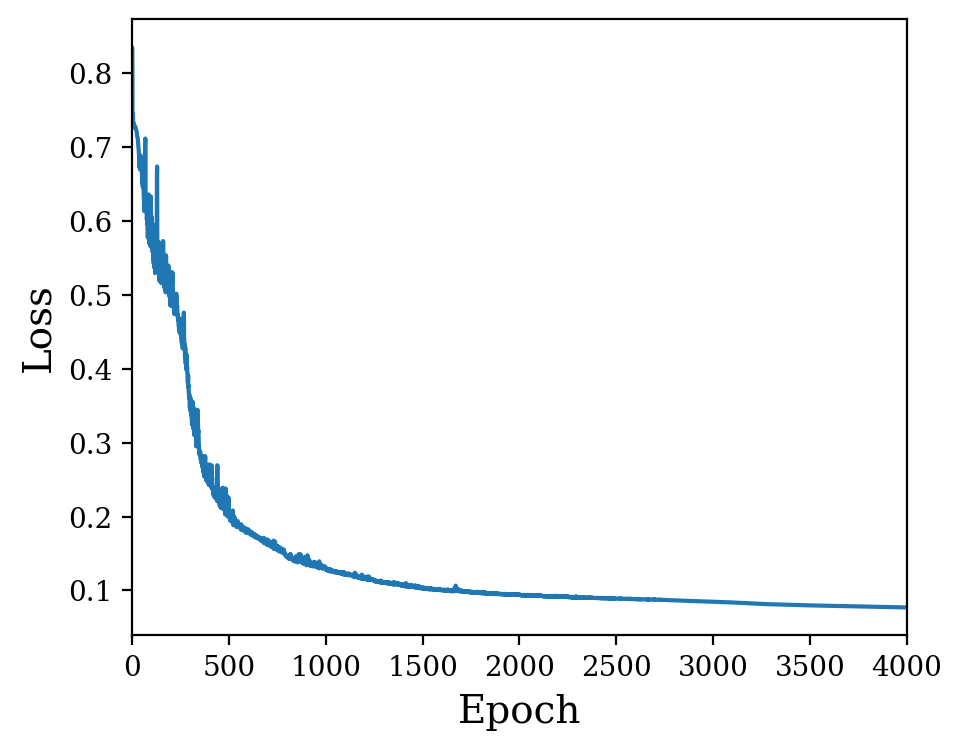

In [44]:
plt.plot(range(num_epochs), losses)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.xlim([0,num_epochs])
plt.show()

The loss does not appear to be unstable thanks to our rate scheduling and gradient clipping. One could argue that the loss hasn't exactly flattened out to convergence yet, but training the network is costly as-is and we're only undertaking an exploratory analysis here. 

Our next validation step is to check the performance of the forecaster within the training data: 

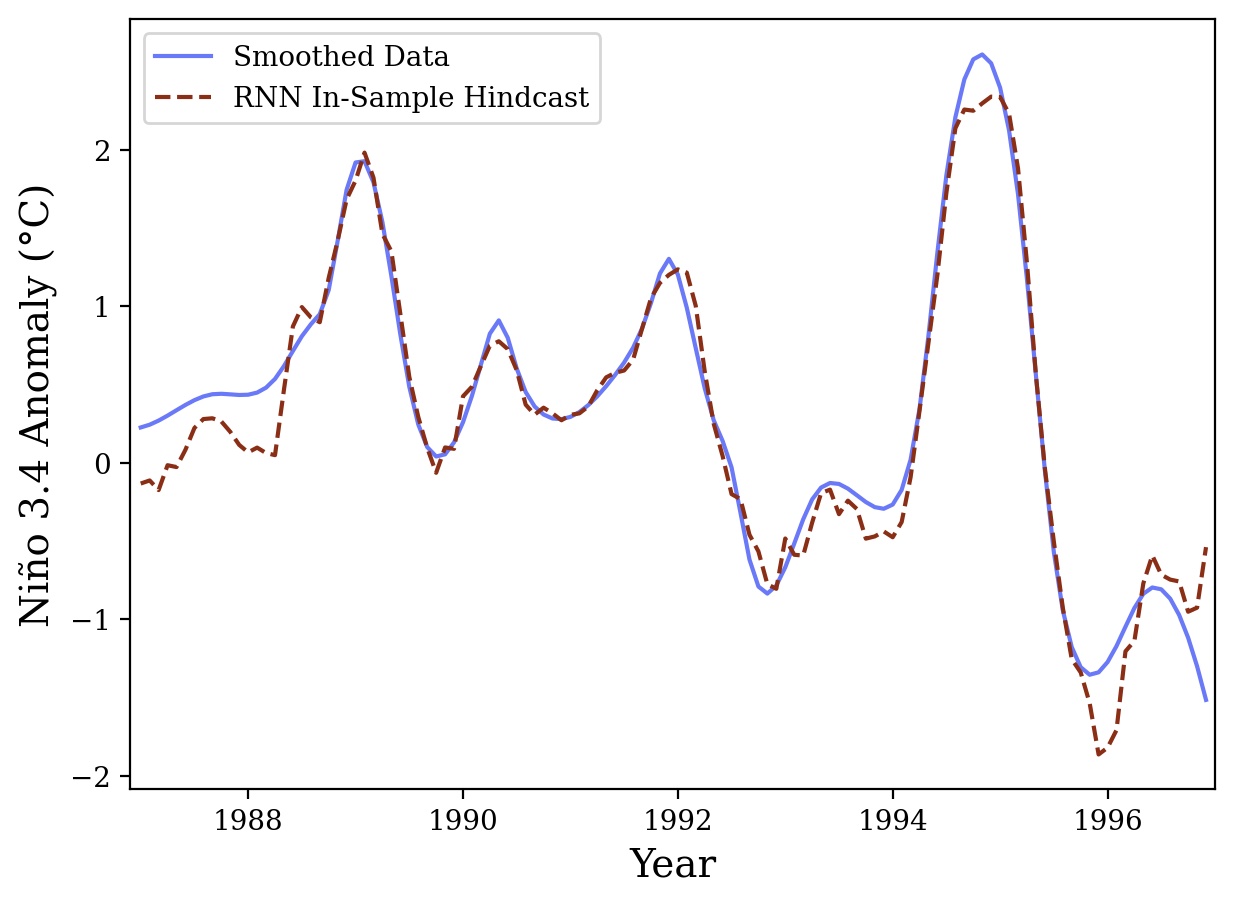

In [45]:
# Make predictions within the sample
rnn_forecaster.eval()
with torch.no_grad():
    in_sample_hindcasts = rnn_forecaster(X.unsqueeze(2)).squeeze(2).numpy()

# Plot results
plt.figure(figsize=(7, 5))
plt.plot(times_final, y[-1].numpy(), label='Smoothed Data', color="xkcd:cornflower", linestyle="solid", linewidth=1.5)
plt.plot(times_final, in_sample_hindcasts[-1], label='RNN In-Sample Hindcast', color="xkcd:red brown", linestyle="dashed", linewidth=1.5)
plt.legend(fontsize=10)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Niño 3.4 Anomaly (°C)", fontsize=14)
plt.xlim([1986.9,1997])
plt.show()

Now make a hindcast on the "test set", which for us is orbit slice over the time range from January 1993 to December 2002.

In [46]:
# Input a smoothed slice and predict from it 
times_test = t_years[(t_years >= 1993) & (t_years < 2003)]
smoothed_test_slice = get_smoothed_slice(times_test, anomaly_test_in, s=smoothing_param)
X_genl = torch.tensor(smoothed_test_slice, dtype=torch.float32).unsqueeze(0)

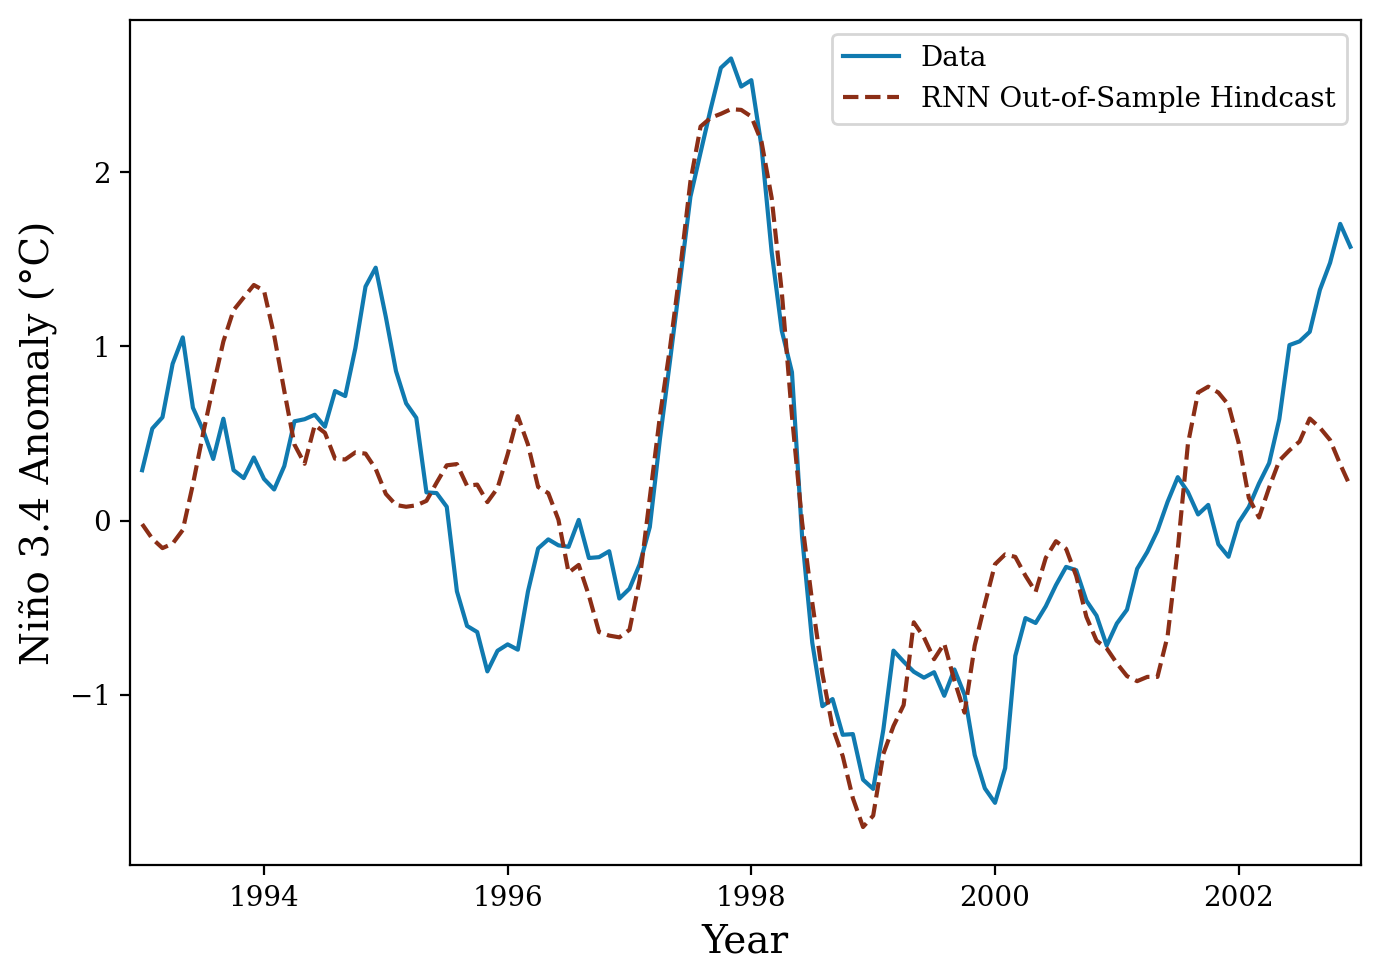

In [47]:
with torch.no_grad():
    pred_genl = rnn_forecaster(X_genl.unsqueeze(2)).squeeze(2).numpy()

plt.figure(figsize=(7, 5))
plt.plot(times_test, anomaly_test_out, label="Data", color="xkcd:nice blue", linestyle="solid", linewidth=1.5)
plt.plot(times_test, pred_genl[0], label="RNN Out-of-Sample Hindcast", color="xkcd:red brown", linestyle="dashed", linewidth=1.5)
plt.legend(fontsize=10)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Niño 3.4 Anomaly (°C)", fontsize=14)
plt.xlim([1992.9,2003])
plt.tight_layout()
plt.savefig("enso_rnn_hindcast.png", dpi=400)
plt.show()

We see that the hindcast does a good job of learning genuinely nonlinear features. In particular, it seems to recognize when an "upswell" in the anomaly is about to happen, and can predict its magnitude reasonably accurate. However, the "downswells" are resolved less well, and there are noticeable phase errors in both upswells and downswells (the network tends to predict them a few months before they happen). 

So, the RNN is definitely capturing some qualitative features of the time series, but its ability for *quantitative* forecasting doesn't seem to be able to compete with AR(2); a lengthy training time also doesn't help the case of the RNN. We conclude that, of the simple forecasting methods surveyed here,

1) the simple AR(2) model did the best job,
2) the fully-connected ANN performed unacceptably terribly, and
3) the RNN showed some promise but was definitely not good enough to compete with AR(2). 

### Closing Thoughts

While the RNN failed to give an acceptable hindcast, it could at least learn *something* about the oscillations. Perhaps "ensemble forecasting" using the techniques of uncertainty quantification for neutral networks could produce a better result? Incidentally, it's worth mentioning that an ANN's predictions are functionally useless without uncertainty bounds, so even if RNN was competitive with AR(2) here we would need to do some UQ to rigorously assess its performance. 

Alternatively, perhaps the "black box" neural network methods applied here can be improved upon by more interpretable nonlinear methods. For instance, it may be worth investigating spectral methods and methods based on embeddings. Additionally, perhaps dynamic mode decomposition could identify some of the "main" oscillations in our time series and provide a simple, robust forecasting scheme. 